In [3]:
import logging
import argparse
from sys import argv, exit, path
from os import system
from os.path import exists, dirname
import datetime
import findspark  # find spark home directory
findspark.init('/usr/hdp/current/spark2-client')
from pyspark.sql import HiveContext
from pyspark.sql.functions import pandas_udf, PandasUDFType

import pandas as pd

path.insert(0, "/home/prod/git/common/config_utils")
from load_user_config import load_config_from_file, convert_namedtuple_to_dict
path.insert(0, "/home/prod/git/common/logging")
from user_logging import assign_log_handler, close_log_handler
path.insert(0, "/home/prod/git/common/pyspark_utils")
from get_spark import get_spark
path.insert(0, "/home/prod/git/common/collect_raw_data_utils")
from get_guobiao_raw_data_missing_days import get_guobiao_raw_data_missing_days
from data_collection import get_raw_records_in_spark
from aggregate_raw_data import aggregate_raw_data
import pyspark.sql.functions as F

In [213]:
df_pdf = pd.read_csv("/home/wchen/LNAA2AA11K5027328_all.csv")

In [214]:
df_pdf.columns = [x.split('.')[1] for x in df_pdf.columns]
df_pdf.head()

vin vintype             ts  veh_st  veh_charge_st  \
0  LNAA2AA11K5027328     A26  1575641825000       1              3   
1  LNAA2AA11K5027328     A26  1575639585000       1              3   
2  LNAA2AA11K5027328     A26  1575641835000       1              3   
3  LNAA2AA11K5027328     A26  1575639595000       1              3   
4  LNAA2AA11K5027328     A26  1575639605000       1              3   

   veh_runmode  veh_spd  veh_odo  veh_volt  veh_curr    ...     esd_curr  \
0            1      0.0      0.0     326.3       1.0    ...          1.0   
1            1      0.0      0.0     326.3       0.8    ...          0.8   
2            1      0.0      0.0     326.3       0.9    ...          0.9   
3            1      0.0      0.0     326.3       0.8    ...          0.8   
4            1      0.0      0.0     326.3       0.8    ...          0.8   

   esd_sc_cnt  esd_frame_start  esd_frame_sc_cnt  \
0          92                1                92   
1          92                1                92   
2          92                1                92   
3          92                1                92   
4          92                1                92   

                                   esd_frame_sc_list  esd_temp_subsys_cnt  \
0  3.563|3.566|3.568|3.564|3.563|3.567|3.563|3.56...                    1   
1  3.564|3.567|3.569|3.565|3.565|3.569|3.564|3.56...                    1   
2  3.563|3.566|3.568|3.564|3.563|3.567|3.563|3.56...                    1   
3  3.564|3.567|3.569|3.565|3.564|3.568|3.564|3.56...                    1   
4  3.564|3.567|3.569|3.565|3.565|3.567|3.564|3.56...                    1   

   esd_temp_subsys_seq  esd_temp_probe_cnt  \
0                    1                  32   
1                    1                  32   
2                    1                  32   
3                    1                  32   
4                    1                  32   

                                 esd_temp_probe_list       day  
0  20|20|20|20|20|20|20|20|19|20|20|20|19|20|19|2...  20191206  
1  19|20|20|20|19|20|20|20|19|20|19|20|19|20|19|1...  20191206  
2  20|20|20|20|20|20|20|20|19|20|20|20|19|20|19|2...  20191206  
3  19|20|20|20|19|20|20|20|19|20|19|20|19|20|19|1...  20191206  
4  19|20|20|20|19|20|20|20|19|20|19|20|19|20|19|2...  20191206  

[5 rows x 82 columns]

In [215]:
vintype ='A26'
#num_modules = tmp["NUMBER_OF_TEMP_MODULES"][vintype]
num_modules = 32

In [216]:
#df_pdf = df_pdf.rename({'a26_gb_orc.esd_temp_probe_list':'esd_temp_probe_list'})

In [217]:
temperature_list = ["sensor_" + str(s) for s in range(1, num_modules+1)]

In [218]:
voltage_list = ["voltage_" + str(s) for s in range(1, 92+1)]

In [219]:
df_pdf[temperature_list] = df_pdf.esd_temp_probe_list.str.split("|",expand=True) 

In [220]:
df_pdf[voltage_list] = df_pdf.esd_frame_sc_list.str.split("|",expand=True) 

In [221]:
import numpy as np
null_signals = np.all(pd.isnull(df_pdf[temperature_list]), axis = 1)
df_pdf[temperature_list] = df_pdf[temperature_list].loc[~null_signals].astype(np.float)

In [222]:
null_signals = np.all(pd.isnull(df_pdf[voltage_list]), axis = 1)
df_pdf[voltage_list] = df_pdf[voltage_list].loc[~null_signals].astype(np.float)

In [223]:
#df_pdf = df_pdf.reset_index()

def convert_ts_to_datetime(ts_series):
    """
    This function converts timestamps into datetime objects

    Parameters
    ----------
    ts_series : Pandas Series of timestamps

    Returns
    ----------
    datetime_series : Pandas Series of strings of datetimes

    Notes
    -----
    This function can accept these ts units: s, ms, us, ns
    """

    available_units = {19:'ns', 16:'us', 13:'ms', 10:'s'}
    time_zone = 'Asia/Hong_Kong'

    def _epoch_time_converter(t):
        t = str(t)
        if len(t) in available_units.keys():
            unit = available_units[len(t)]
        else:
            raise AttributeError('{} is not in valid epoch time format'.format(t))
        return pd.to_datetime(t, unit=unit, utc=True).tz_convert(time_zone)

    digits = ts_series.astype(str).str.len()
    # only one unit of ts is in the whole series,
    # so use vectorized method to convert
    if len(digits.unique()) == 1:
        if digits.iloc[0] in available_units.keys():
            unit_of_ts = available_units[digits.iloc[0]]
            datetime_series = pd.to_datetime(ts_series, unit=unit_of_ts,
                                             utc=True).dt.tz_convert(time_zone)
        else:
            raise AttributeError('input ts is not in valid epoch time format')

    # several units of ts found,
    # has to convert to datetime using apply (i.e., one row at a time)
    else:
        datetime_series = ts_series.apply(_epoch_time_converter)

    return datetime_series
df_pdf['ts'] = convert_ts_to_datetime(df_pdf['ts'])

In [224]:
df_pdf = df_pdf.set_index('ts')

In [225]:
df_pdf.sort_index(inplace=True)

In [226]:
df_pdf.head()

vin vintype  veh_st  veh_charge_st  \
ts                                                                            
2019-12-06 21:39:45+08:00  LNAA2AA11K5027328     A26       1              3   
2019-12-06 21:39:55+08:00  LNAA2AA11K5027328     A26       1              3   
2019-12-06 21:40:05+08:00  LNAA2AA11K5027328     A26       1              3   
2019-12-06 21:40:15+08:00  LNAA2AA11K5027328     A26       1              3   
2019-12-06 21:40:25+08:00  LNAA2AA11K5027328     A26       1              3   

                           veh_runmode  veh_spd  veh_odo  veh_volt  veh_curr  \
ts                                                                             
2019-12-06 21:39:45+08:00            1      0.0      0.0     326.3       0.8   
2019-12-06 21:39:55+08:00            1      0.0      0.0     326.3       0.8   
2019-12-06 21:40:05+08:00            1      0.0      0.0     326.3       0.8   
2019-12-06 21:40:15+08:00            1      0.0      0.0     326.3       0.8   
2019-12-06 21:40:25+08:00            1      0.0      0.0     326.3       0.7   

                           veh_soc     ...      voltage_83  voltage_84  \
ts                                     ...                               
2019-12-06 21:39:45+08:00       29     ...           3.562       3.564   
2019-12-06 21:39:55+08:00       29     ...           3.563       3.565   
2019-12-06 21:40:05+08:00       29     ...           3.562       3.566   
2019-12-06 21:40:15+08:00       29     ...           3.562       3.566   
2019-12-06 21:40:25+08:00       29     ...           3.562       3.566   

                           voltage_85  voltage_86  voltage_87  voltage_88  \
ts                                                                          
2019-12-06 21:39:45+08:00       3.565       3.565       3.565       3.566   
2019-12-06 21:39:55+08:00       3.564       3.565       3.565       3.565   
2019-12-06 21:40:05+08:00       3.565       3.565       3.565       3.566   
2019-12-06 21:40:15+08:00       3.564       3.565       3.564       3.565   
2019-12-06 21:40:25+08:00       3.565       3.564       3.565       3.565   

                           voltage_89  voltage_90  voltage_91  voltage_92  
ts                                                                         
2019-12-06 21:39:45+08:00       3.565       3.565       3.566       3.566  
2019-12-06 21:39:55+08:00       3.566       3.564       3.567       3.567  
2019-12-06 21:40:05+08:00       3.566       3.565       3.566       3.567  
2019-12-06 21:40:15+08:00       3.566       3.565       3.567       3.567  
2019-12-06 21:40:25+08:00       3.566       3.564       3.567       3.567  

[5 rows x 205 columns]

In [277]:
df_pdf[temperature_list].iloc[49781:,:].iplot(title="LNAA2AA11K5027328", mode = "lines+markers")

Text(0.5,0,'ts')

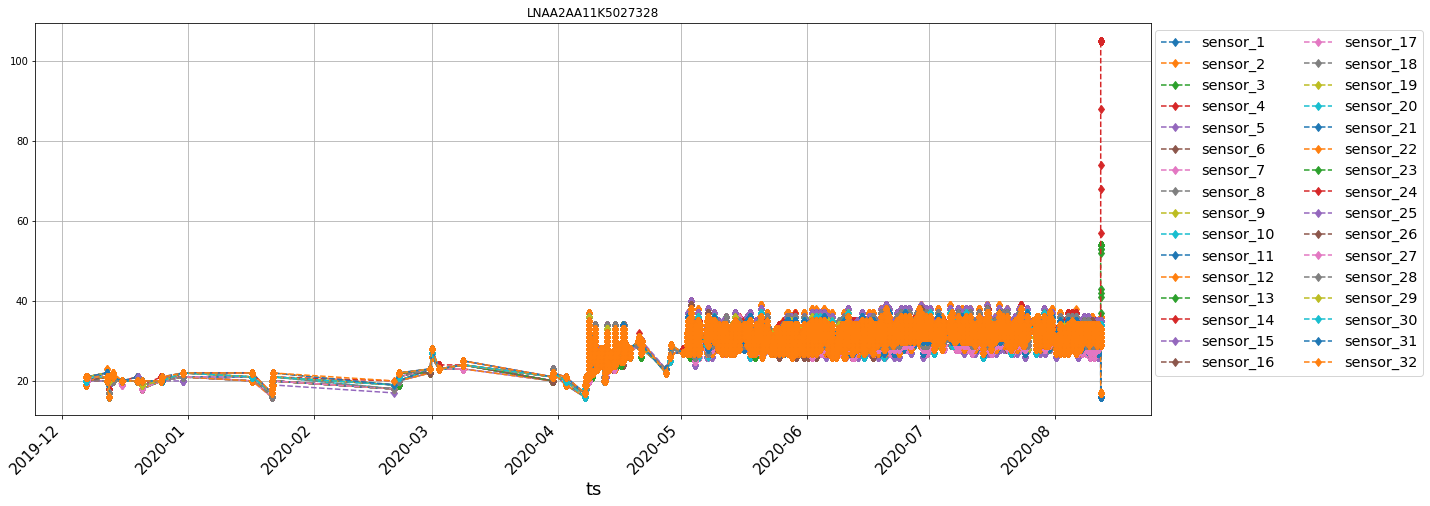

In [30]:
"""
prod_date = pd.to_datetime('20200707')
earliest_date = prod_date - timedelta(30)

all_days = [(earliest_date + timedelta(i)).strftime("%Y%m%d") for i in range(30+1)]
"""
import matplotlib.pyplot as plt
%matplotlib inline
df_pdf[temperature_list].plot(   
    figsize=(20, 8), 
    style="d--", 
    grid=True, 
    #xlim=(earliest_date_ - timedelta(2), prod_date_ + timedelta(3)),
    title='LNAA2AA11K5027328')
plt.legend(fontsize='x-large', ncol=2, bbox_to_anchor=(1.25, 1.00))
plt.xticks(fontsize=15, rotation=45)
plt.xlabel('ts', fontsize=18)

In [31]:
length = len(df_pdf) * 0.7
print length

318428.6


In [33]:
print len(df_pdf) 

454898


Text(0.5,0.98,'LNAA2AA11K5027328')

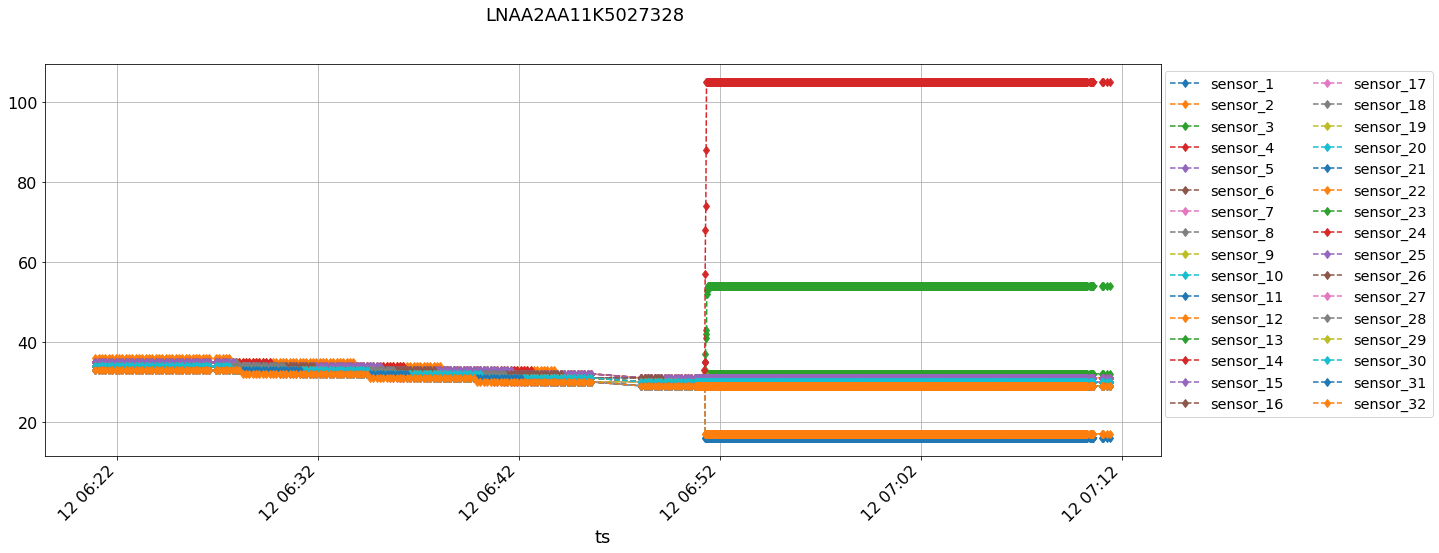

In [45]:
%matplotlib inline
df_pdf[temperature_list].iloc[453550:,:].plot(   
    figsize=(20, 8), 
    style="d--", 
    grid=True, 
    #xlim=(earliest_date_ - timedelta(2), prod_date_ + timedelta(3)),
    #title='LNAA2AA11K5027328', fontsize=18
)
plt.legend(fontsize='x-large', ncol=2, bbox_to_anchor=(1.25, 1.00))
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.xlabel('ts', fontsize=18)
plt.suptitle('LNAA2AA11K5027328', fontsize=18)

In [46]:
train = df_pdf.iloc[0:318428,:][temperature_list]
test = df_pdf.iloc[318429:,:][temperature_list]

In [47]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df_pdf[temperature_list], test_size=0.2)
#train.count()

In [48]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [49]:
mse = {}
r2 = {}

In [52]:
for i in range(1, 33):
    print("Process module " + str(i))
    y = train['sensor_' + str(i)]
    X = train.drop(['sensor_' + str(i)], axis=1)
    reg = LinearRegression().fit(X, y)
    print("Done with training module " + str(i))
    reg.score(X, y)
    X_test = test.drop(['sensor_' + str(i)], axis=1)        
    y_pred = reg.predict(X_test)
    print("Done with testing module " + str(i))
    mse_value = mean_squared_error(test['sensor_' + str(i)], y_pred)
    mse[i] = mse_value
    r2_value = r2_score(test['sensor_' + str(i)], y_pred)
    r2[i] = r2_value

Process module 1
Done with training module 1
Done with testing module 1
Process module 2
Done with training module 2
Done with testing module 2
Process module 3
Done with training module 3
Done with testing module 3
Process module 4
Done with training module 4
Done with testing module 4
Process module 5
Done with training module 5
Done with testing module 5
Process module 6
Done with training module 6
Done with testing module 6
Process module 7
Done with training module 7
Done with testing module 7
Process module 8
Done with training module 8
Done with testing module 8
Process module 9
Done with training module 9
Done with testing module 9
Process module 10
Done with training module 10
Done with testing module 10
Process module 11
Done with training module 11
Done with testing module 11
Process module 12
Done with training module 12
Done with testing module 12
Process module 13
Done with training module 13
Done with testing module 13
Process module 14
Done with training module 14
Done 

In [53]:
mse_df = pd.DataFrame.from_dict(mse, orient='index')
mse_df = mse_df.reset_index()
print(type(mse_df))
mse_df.columns = ['index', 'mse']
mse_df.sort_values(by=['mse'])

<class 'pandas.core.frame.DataFrame'>


index       mse
14     15  0.046645
12     13  0.054797
3       4  0.059768
21     22  0.062130
18     19  0.063764
2       3  0.075156
19     20  0.075504
25     26  0.077533
7       8  0.078607
5       6  0.079892
20     21  0.080155
6       7  0.080758
8       9  0.081355
22     23  0.081970
15     16  0.084390
16     17  0.084445
29     30  0.084661
9      10  0.085185
10     11  0.088268
17     18  0.090388
11     12  0.094752
4       5  0.099367
28     29  0.101688
24     25  0.106451
26     27  0.106998
30     31  0.110285
31     32  0.117636
23     24  0.118559
27     28  0.129128
0       1  0.144596
1       2  0.189799
13     14  0.378553

In [120]:
train_v = df_pdf.iloc[0:20000,:][voltage_list]
test_v = df_pdf.iloc[20001:,:][voltage_list]
#train_v,test_v = train_test_split(df_pdf[voltage_list], test_size=0.2)
mse_v = {}
r2_v = {}

for i in range(1, 92):
    print("Process module " + str(i))
    y = train_v['voltage_' + str(i)]
    X = train_v.drop(['voltage_' + str(i)], axis=1)
    reg = LinearRegression().fit(X, y)
    print("Done with training module " + str(i))
    reg.score(X, y)
    X_test = test_v.drop(['voltage_' + str(i)], axis=1)        
    y_pred = reg.predict(X_test)
    print("Done with testing module " + str(i))
    mse_value = mean_squared_error(test_v['voltage_' + str(i)], y_pred)
    
    mse_v[i] = ((test_v['voltage_' + str(i)] - y_pred) ** 2).nlargest(10).mean()
    r2_value = r2_score(test_v['voltage_' + str(i)], y_pred)
    r2_v[i] = r2_value

pd.DataFrame.from_dict(mse_v, orient='index')

Process module 1
Done with training module 1
Done with testing module 1
Process module 2
Done with training module 2
Done with testing module 2
Process module 3
Done with training module 3
Done with testing module 3
Process module 4
Done with training module 4
Done with testing module 4
Process module 5
Done with training module 5
Done with testing module 5
Process module 6
Done with training module 6
Done with testing module 6
Process module 7
Done with training module 7
Done with testing module 7
Process module 8
Done with training module 8
Done with testing module 8
Process module 9
Done with training module 9
Done with testing module 9
Process module 10
Done with training module 10
Done with testing module 10
Process module 11
Done with training module 11
Done with testing module 11
Process module 12
Done with training module 12
Done with testing module 12
Process module 13
Done with training module 13
Done with testing module 13
Process module 14
Done with training module 14
Done 

0
1    0.659839
2    0.033396
3    0.020488
4    0.094175
5    0.233335
6    0.306806
7    0.262967
8    1.571435
9    1.041443
10   1.041921
11   0.957547
12   0.649077
13   0.093124
14   0.146490
15   0.111691
16   0.378652
17   0.425827
18   0.115763
19   1.906229
20   0.082937
21   0.489167
22   0.093053
23   0.258376
24   0.089684
25   0.095323
26   0.072469
27   0.062482
28   0.052067
29   0.100577
30   0.177116
31   4.566454
32   0.028249
33   0.044008
34   0.007447
35   0.001498
36   0.015597
37   0.090216
38   0.052195
39   0.027782
40   0.093804
41   0.151417
42   0.048397
43   0.001797
44   0.022901
45   0.073210
46   0.008111
47   0.015500
48   0.094068
49   0.136249
50   0.143352
51   0.095382
52   0.174758
53   0.035955
54   0.185985
55   0.373601
56   0.225845
57   0.049880
58   0.498300
59   0.044446
60   0.184224
61   1.771704
62  11.154601
63   0.916552
64   3.670520
65   8.692388
66   1.882576
67   3.583629
68   0.284162
69   0.065864
70   0.102973
71   0.637283
72   0.044728
73   0.130837
74   0.099403
75   0.030735
76   0.160028
77   0.759922
78   0.463541
79   0.189752
80   0.579440
81   0.023880
82   0.021775
83   0.059646
84   0.157680
85   0.003289
86   0.139573
87   0.336976
88   0.026185
89   0.000256
90   0.019756
91   0.142905

# Individual sensor study

充电状态分为 1：停车充电，2：行驶充电，3：表充电状态，4：充电完成
数据中没有状态2：行驶充电！
The earlist recorded day: 20191206
The last recorded day: 20200812


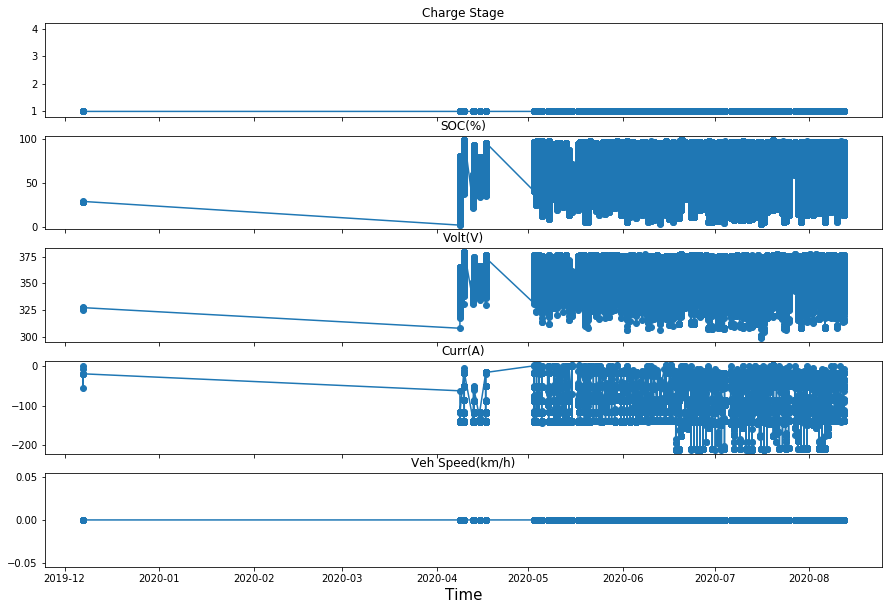

In [132]:
 print('充电状态分为 1：停车充电，2：行驶充电，3：表充电状态，4：充电完成')
print('数据中没有状态2：行驶充电！')
df2 = df_pdf[(df_pdf['veh_charge_st']==1)]  # & df[' esd_curr']>=0

print("The earlist recorded day: {}".format(df_pdf.iloc[0]['day']))
print("The last recorded day: {}".format(df_pdf.iloc[-1]['day']))

df2=df2.reset_index()
#datetime = convert_ts_to_datetime(df2['ts'])
datetime = df2['ts']
x_values = datetime # df2.index.values

# plt.rcParams['figure.figsize'] = [15, 10]
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,sharex='col',figsize = [15, 10])
ax1.plot(x_values, df2['veh_charge_st'],'-o')
ax1.set_title('Charge Stage')
ax1.set_ylim(0.8,4.2)
ax2.plot(x_values, df2['veh_soc'],'-o')
ax2.set_title('SOC(%)')
ax3.plot(x_values, df2['esd_volt'],'-o')
ax3.set_title('Volt(V)')
#ax3.set_ylim(0, 5)
ax4.plot(x_values, df2['esd_curr'],'-o')
ax4.set_title('Curr(A)')
ax5.plot(x_values, df2['veh_spd'],'-o')
ax5.set_title('Veh Speed(km/h)')
ax5.set_xlabel('Time',size=15)
plt.show()

In [111]:
result_list = []

In [55]:
#df_pdf = df_pdf.drop(df_pdf.columns[0], axis=1)
#df_pdf.head()

In [112]:
schema = "sensor_id int"
schema += ", fast_charging string, slow_charging string, driving string"

columns = [element.split(" ")[0] for element in \
           schema.split(", ")]

In [113]:
filter1 = df_pdf['veh_curr'] < -30
filter2 = df_pdf['veh_charge_st'] == 1
fast_charging_conds = filter1 & filter2

In [114]:
filter1 = df_pdf['veh_curr'] >= -30
filter2 = df_pdf['veh_curr'] < 0
filter3 = df_pdf['veh_charge_st'] == 1
slow_charging_conds = filter1 & filter2 & filter3

In [115]:
filter4 = df_pdf['veh_charge_st'] == 3
filter5 = df_pdf['veh_st'] == 1
driving_conds = filter4 & filter5

In [231]:
df_pdf2 = df_pdf.copy()
df_pdf2 = df_pdf2[~df_pdf2.index.duplicated()]

In [329]:
def _compute_max_rate(df, temperature_list, period):   
    #df[df >= 85] = np.nan   
    #df[df <= -40] = np.nan   
    df = df.reset_index()
    """
    # filter out bad records with average jump greater than 10 degree across all sensors
    temp_pre_diff_10s = df.mean(axis=1).diff(periods=1).fillna(0)
    ts_pre_diff = df["ts"].diff(periods=1).fillna(0).dt.seconds
    mask = (temp_pre_diff_10s > -10) & (temp_pre_diff_10s < 10)
    # only filter out those recods with ts diff not higher than 11 seconds under the above condition
    mask = mask | (ts_pre_diff > 11)
    df = df[mask]
    #"""
        
     ###
    df['ts'] = df['ts'].dt.tz_localize(None)###
    df = df.sort_values(by='ts')###
    df = df.set_index(['ts'], inplace=False)###
    ts_diff = pd.Series(df.index, index=df.index).diff(periods=period).iloc[1:]###
    
    ts_diff = ts_diff.dt.seconds.div(60, fill_value=0)

    temp_diff = df[temperature_list].max(axis=1).diff(periods=period).iloc[1:]
    #x.append(temp_diff)
    rate_df = temp_diff.div(ts_diff, axis=0)
    #rate_df.dropna(inplace=True)
    rate_df_increasing = rate_df#[rate_df > 1]
    
    thrd = 0.1
    if period == 30:
        thrd = 4.9
    mask = ts_diff > thrd
    rate_df_increasing = rate_df_increasing[mask]
    
    #rate_series = pd.DataFrame(sorted(it.chain(*rate_df_increasing.values)))
    result_list.append(rate_df_increasing)
    
    if len(rate_df_increasing):
        ind_max = rate_df_increasing.idxmax()
        #print("*************")
        #print(ts_diff)
        print("ind_max is " + ind_max.strftime('%Y-%m-%d %H:%M:%S'))
        #print(rate_df_increasing.loc[ind_max])
        if isinstance(rate_df_increasing.loc[ind_max], pd.Series):
            print(rate_df_increasing.loc[ind_max])
            #print(rate_df_increasing.loc[ind_max].at[ind_max][1])
            #rate = round(rate_df_increasing.loc[ind_max].at[ind_max][1], 2)
            #temp_diff = round(temp_diff.loc[ind_max].at[ind_max][1], 2)
            #time_diff = round(ts_diff.loc[ind_max].at[ind_max][1], 3)
            rate = rate_df_increasing.loc[ind_max].at[ind_max][1]
            temp_diff = temp_diff.loc[ind_max].at[ind_max][1]
            time_diff = ts_diff.loc[ind_max].at[ind_max][1]
        else:    
            print(type(rate_df_increasing.loc[ind_max]))
            rate = round(rate_df_increasing.loc[ind_max], 2)
            if isinstance(temp_diff.loc[ind_max], pd.Series):
                temp_diff = temp_diff.loc[ind_max].at[ind_max][1]
            else:
                 temp_diff = round(temp_diff.loc[ind_max], 3)
            if isinstance(ts_diff.loc[ind_max], pd.Series):
                time_diff = ts_diff.loc[ind_max].at[ind_max][1]
            else:
                time_diff = round(ts_diff.loc[ind_max], 3)

    else:
        rate, temp_diff, time_diff, ind_max = None, None, None, None

    return rate, temp_diff, time_diff, ind_max

In [330]:
return_dict = {}

def compute_rate(sensor_id):
    return_dict[sensor_id] = {}
    temp_dict = return_dict[sensor_id]
    fast_charging_df = df_pdf[fast_charging_conds].copy()
    if not fast_charging_df.empty:
        rate, temp_diff, time_diff, ind_max = _compute_max_rate(fast_charging_df, [sensor_id], 6)
        if rate is not None:
            temp_dict["fast_charging"] = "{}:{}:{}:{}".format(rate, temp_diff, time_diff, ind_max)
        else:
            temp_dict["fast_charging"] = ""
    else:
        temp_dict["fast_charging"] = ""

    slow_charging_df = df_pdf[slow_charging_conds].copy()
    if not slow_charging_df.empty:
        rate, temp_diff, time_diff, ind_max = _compute_max_rate(slow_charging_df, [sensor_id], 6)
        if rate is not None:
            temp_dict["slow_charging"] = "{}:{}:{}:{}".format(rate, temp_diff, time_diff, ind_max)
        else:
            temp_dict["slow_charging"] = ""
    else:
        temp_dict["slow_charging"] = ""

    driving_df = df_pdf[driving_conds].copy()
    if not driving_df.empty:
        rate, temp_diff, time_diff, ind_max = _compute_max_rate(driving_df, [sensor_id], 6)
        if rate is not None:
            temp_dict["driving"] = "{}:{}:{}:{}".format(rate, temp_diff, time_diff, ind_max)
        else:
            temp_dict["driving"] = ""
    else:
        temp_dict["driving"] = ""
    print(temp_dict)

for i in range(1, 33):
    print("start module_" + str(i))
    compute_rate('sensor_' + str(i))
    print("done with module_" + str(i))
return_df_all = pd.DataFrame(return_dict, columns=columns, index=[None])

start module_1
ind_max is 2020-06-19 05:22:15
<type 'numpy.float64'>
ind_max is 2020-04-10 00:21:15
<type 'numpy.float64'>
ind_max is 2019-12-06 21:48:05
<type 'numpy.float64'>
{'fast_charging': '3.0:3.0:1.0:2020-06-19 05:22:15', 'driving': '1.0:1.0:1.0:2019-12-06 21:48:05', 'slow_charging': '1.0:1.0:1.0:2020-04-10 00:21:15'}
done with module_1
start module_2
ind_max is 2020-06-23 05:27:55
<type 'numpy.float64'>
ind_max is 2020-05-30 01:28:35
<type 'numpy.float64'>
ind_max is 2020-08-03 10:29:35
ts
2020-08-03 10:29:35    0.0
2020-08-03 10:29:35    1.2
dtype: float64
{'fast_charging': '3.0:3.0:1.0:2020-06-23 05:27:55', 'driving': '1.2:1.0:0.833333333333:2020-08-03 10:29:35', 'slow_charging': '1.0:1.0:1.0:2020-05-30 01:28:35'}
done with module_2
start module_3
ind_max is 2020-06-19 05:22:25
<type 'numpy.float64'>
ind_max is 2020-04-10 00:22:15
<type 'numpy.float64'>
ind_max is 2020-08-12 06:51:28
<type 'numpy.float64'>
{'fast_charging': '3.0:3.0:1.0:2020-06-19 05:22:25', 'driving': '13.3

ind_max is 2020-06-18 06:10:35
<type 'numpy.float64'>
ind_max is 2020-06-24 05:33:55
<type 'numpy.float64'>
ind_max is 2020-04-13 20:35:05
<type 'numpy.float64'>
{'fast_charging': '2.0:2.0:1.0:2020-06-18 06:10:35', 'driving': '1.2:1.0:0.833:2020-04-13 20:35:05', 'slow_charging': '1.0:1.0:1.0:2020-06-24 05:33:55'}
done with module_24
start module_25
ind_max is 2020-06-18 06:11:05
<type 'numpy.float64'>
ind_max is 2020-04-10 00:48:55
<type 'numpy.float64'>
ind_max is 2019-12-20 14:01:35
<type 'numpy.float64'>
{'fast_charging': '2.0:2.0:1.0:2020-06-18 06:11:05', 'driving': '1.0:1.0:1.0:2019-12-20 14:01:35', 'slow_charging': '1.0:1.0:1.0:2020-04-10 00:48:55'}
done with module_25
start module_26
ind_max is 2020-06-18 06:10:55
<type 'numpy.float64'>
ind_max is 2020-05-21 03:38:05
<type 'numpy.float64'>
ind_max is 2020-04-14 13:21:25
<type 'numpy.float64'>
{'fast_charging': '2.0:2.0:1.0:2020-06-18 06:10:55', 'driving': '1.2:1.0:0.833:2020-04-14 13:21:25', 'slow_charging': '1.0:1.0:1.0:2020-05

In [331]:
#print(return_dict)
return_df_all = pd.DataFrame(return_dict)#, columns=columns, index=[None])

In [332]:
return_df_all.head()

sensor_1  \
driving        1.0:1.0:1.0:2019-12-06 21:48:05   
fast_charging  3.0:3.0:1.0:2020-06-19 05:22:15   
slow_charging  1.0:1.0:1.0:2020-04-10 00:21:15   

                                     sensor_10  \
driving        1.0:1.0:1.0:2020-01-21 17:25:45   
fast_charging  2.0:2.0:1.0:2020-06-18 06:10:35   
slow_charging  1.0:1.0:1.0:2020-05-04 13:04:15   

                                                   sensor_11  \
driving        42.86:5.0:0.0833333333333:2020-08-12 06:51:15   
fast_charging                3.0:3.0:1.0:2020-06-19 05:22:25   
slow_charging                1.0:1.0:1.0:2020-04-10 00:41:35   

                                                   sensor_12  \
driving        17.14:2.0:0.0833333333333:2020-08-12 06:51:15   
fast_charging                3.0:3.0:1.0:2020-06-30 05:30:25   
slow_charging                1.0:1.0:1.0:2020-04-10 00:37:45   

                                        sensor_13  \
driving        80.0:12.0:0.15:2020-08-12 06:51:28   
fast_charging     3.0:3.0:1.0:2020-06-19 05:22:35   
slow_charging     1.0:1.0:1.0:2020-06-27 05:28:25   

                                          sensor_14  \
driving        113.33:17.0:0.15:2020-08-12 06:51:28   
fast_charging       3.0:3.0:1.0:2020-06-19 05:22:25   
slow_charging       1.0:1.0:1.0:2020-05-19 08:22:05   

                                     sensor_15  \
driving        1.0:1.0:1.0:2020-01-21 11:28:25   
fast_charging  3.0:3.0:1.0:2020-06-19 05:22:25   
slow_charging  1.0:1.0:1.0:2020-08-06 05:34:55   

                                     sensor_16  \
driving        1.0:1.0:1.0:2019-12-06 21:41:35   
fast_charging  3.0:3.0:1.0:2020-06-26 05:34:25   
slow_charging  1.0:1.0:1.0:2020-04-10 00:48:35   

                                       sensor_17  \
driving        1.2:1.0:0.833:2020-08-03 10:29:55   
fast_charging    3.0:3.0:1.0:2020-06-30 05:30:25   
slow_charging    1.0:1.0:1.0:2020-05-30 01:32:25   

                                                sensor_18  \
driving        1.2:1.0:0.833333333333:2020-08-03 10:29:35   
fast_charging             3.0:3.0:1.0:2020-08-06 05:37:05   
slow_charging             1.0:1.0:1.0:2020-05-30 01:35:55   

                                  ...                      \
driving                           ...                       
fast_charging                     ...                       
slow_charging                     ...                       

                                         sensor_3  \
driving        13.33:2.0:0.15:2020-08-12 06:51:28   
fast_charging     3.0:3.0:1.0:2020-06-19 05:22:25   
slow_charging     1.0:1.0:1.0:2020-04-10 00:22:15   

                                     sensor_30  \
driving        1.0:1.0:1.0:2019-12-06 22:54:35   
fast_charging  2.0:2.0:1.0:2020-06-18 06:10:45   
slow_charging  1.0:1.0:1.0:2020-06-08 06:19:05   

                                     sensor_31  \
driving        1.0:1.0:1.0:2019-12-25 12:02:45   
fast_charging  2.0:2.0:1.0:2020-06-18 06:10:25   
slow_charging  1.0:1.0:1.0:2020-08-01 05:36:35   

                                     sensor_32  \
driving        1.0:1.0:1.0:2019-12-13 13:52:45   
fast_charging  2.0:2.0:1.0:2020-06-18 06:10:45   
slow_charging  1.0:1.0:1.0:2020-08-06 05:35:05   

                                        sensor_4  \
driving        6.67:1.0:0.15:2020-08-12 06:51:28   
fast_charging    3.0:3.0:1.0:2020-06-19 05:22:25   
slow_charging    1.0:1.0:1.0:2020-04-10 00:42:55   

                                        sensor_5  \
driving        6.67:1.0:0.15:2020-08-12 06:51:28   
fast_charging    3.0:3.0:1.0:2020-06-19 05:22:35   
slow_charging    1.0:1.0:1.0:2020-05-04 13:01:05   

                                        sensor_6  \
driving        6.67:1.0:0.15:2020-08-12 06:51:28   
fast_charging    3.0:3.0:1.0:2020-06-19 05:22:25   
slow_charging    1.0:1.0:1.0:2020-05-21 03:31:25   

                                      sensor_7  \
driving        2.0:2.0:1.0:2020-06-22 13:57:25   
fast_charging  3.0:3.0:1.0:2020-06-19 05:22:

In [333]:
df_res = return_df_all.T

In [334]:
pd.set_option('display.max_rows', None)

In [335]:
df_res["driving_rate"] = df_res["driving"].str.split(":", n = 1, expand = True)[0]
df_res["fast_charging_rate"] = df_res["fast_charging"].str.split(":", n = 1, expand = True)[0]
df_res["slow_charging_rate"] = df_res["slow_charging"].str.split(":", n = 1, expand = True)[0]
df_res

driving  \
sensor_1                 1.0:1.0:1.0:2019-12-06 21:48:05   
sensor_10                1.0:1.0:1.0:2020-01-21 17:25:45   
sensor_11  42.86:5.0:0.0833333333333:2020-08-12 06:51:15   
sensor_12  17.14:2.0:0.0833333333333:2020-08-12 06:51:15   
sensor_13             80.0:12.0:0.15:2020-08-12 06:51:28   
sensor_14           113.33:17.0:0.15:2020-08-12 06:51:28   
sensor_15                1.0:1.0:1.0:2020-01-21 11:28:25   
sensor_16                1.0:1.0:1.0:2019-12-06 21:41:35   
sensor_17              1.2:1.0:0.833:2020-08-03 10:29:55   
sensor_18     1.2:1.0:0.833333333333:2020-08-03 10:29:35   
sensor_19                2.0:2.0:1.0:2020-05-03 07:28:55   
sensor_2      1.2:1.0:0.833333333333:2020-08-03 10:29:35   
sensor_20                2.0:2.0:1.0:2020-07-14 12:02:05   
sensor_21                2.0:2.0:1.0:2020-07-24 15:12:45   
sensor_22                1.0:1.0:1.0:2019-12-06 21:46:45   
sensor_23                1.0:1.0:1.0:2019-12-06 23:07:05   
sensor_24              1.2:1.0:0.833:2020-04-13 20:35:05   
sensor_25                1.0:1.0:1.0:2019-12-20 14:01:35   
sensor_26              1.2:1.0:0.833:2020-04-14 13:21:25   
sensor_27                2.0:2.0:1.0:2020-07-24 15:12:55   
sensor_28                1.0:1.0:1.0:2019-12-30 17:14:15   
sensor_29              1.2:1.0:0.833:2020-07-17 05:12:25   
sensor_3              13.33:2.0:0.15:2020-08-12 06:51:28   
sensor_30                1.0:1.0:1.0:2019-12-06 22:54:35   
sensor_31                1.0:1.0:1.0:2019-12-25 12:02:45   
sensor_32                1.0:1.0:1.0:2019-12-13 13:52:45   
sensor_4               6.67:1.0:0.15:2020-08-12 06:51:28   
sensor_5               6.67:1.0:0.15:2020-08-12 06:51:28   
sensor_6               6.67:1.0:0.15:2020-08-12 06:51:28   
sensor_7                 2.0:2.0:1.0:2020-06-22 13:57:25   
sensor_8                 1.0:1.0:1.0:2019-12-06 23:09:35   
sensor_9      1.2:1.0:0.833333333333:2020-05-21 09:21:25   

                             fast_charging                    slow_charging  \
sensor_1   3.0:3.0:1.0:2020-06-19 05:22:15  1.0:1.0:1.0:2020-04-10 00:21:15   
sensor_10  2.0:2.0:1.0:2020-06-18 06:10:35  1.0:1.0:1.0:2020-05-04 13:04:15   
sensor_11  3.0:3.0:1.0:2020-06-19 05:22:25  1.0:1.0:1.0:2020-04-10 00:41:35   
sensor_12  3.0:3.0:1.0:2020-06-30 05:30:25  1.0:1.0:1.0:2020-04-10 00:37:45   
sensor_13  3.0:3.0:1.0:2020-06-19 05:22:35  1.0:1.0:1.0:2020-06-27 05:28:25   
sensor_14  3.0:3.0:1.0:2020-06-19 05:22:25  1.0:1.0:1.0:2020-05-19 08:22:05   
sensor_15  3.0:3.0:1.0:2020-06-19 05:22:25  1.0:1.0:1.0:2020-08-06 05:34:55   
sensor_16  3.0:3.0:1.0:2020-06-26 05:34:25  1.0:1.0:1.0:2020-04-10 00:48:35   
sensor_17  3.0:3.0:1.0:2020-06-30 05:30:25  1.0:1.0:1.0:2020-05-30 01:32:25   
sensor_18  3.0:3.0:1.0:2020-08-06 05:37:05  1.0:1.0:1.0:2020-05-30 01:35:55   
sensor_19  3.0:3.0:1.0:2020-06-19 05:22:15  1.0:1.0:1.0:2020-04-10 00:11:05   
sensor_2   3.0:3.0:1.0:2020-06-23 05:27:55  1.0:1.0:1.0:2020-05-30 01:28:35   
sensor_20  3.0:3.0:1.0:2020-06-19 05:22:35  1.0:1.0:1.0:2020-04-10 00:41:15   
sensor_21  3.0:3.0:1.0:2020-06-19 05:22:25  1.0:1.0:1.0:2020-04-10 00:04:55   
sensor_22  3.0:3.0:1.0:2020-06-19 05:22:35  1.0:1.0:1.0:2020-04-10 00:22:15   
sensor_23  2.0:2.0:1.0:2020-06-18 06:10:35  1.0:1.0:1.0:2020-05-21 03:34:05   
sensor_24  2.0:2.0:1.0:2020-06-18 06:10:35  1.0:1.0:1.0:2020-06-24 05:33:55   
sensor_25  2.0:2.0:1.0:2020-06-18 06:11:05  1.0:1.0:1.0:2020-04-10 00:48:55   
sensor_26  2.0:2.0:1.0:2020-06-18 06:10:55  1.0:1.0:1.0:2020-05-21 03:38:05   
sensor_27  3.0:3.0:1.0:2020-06-19 05:22:35  1.0:1.0:1.0:2020-05-04 12:58:35   
sensor_28  3.0:3.0:1.0:2020-06-19 05:22:35  1.0:1.0:1.0:2020-04-10 00:48:35   
sensor_29  2.0:2.0:1.0:2020-06-18 06:10:25  1.0:1.0:1.0:2020-08-04 05:28:05   
sensor_3   3.0:3.0:1.0:2020-06-19 05:22:25  1.0:1.0:1.0:2020-04-10 00:22:15   
sensor_30  2.0:2.0:1.0:2020-06-18 06:10:45  1.0:1.0:1.0:2020-06-08 06:19:05   
sensor_31  2.0:2.0:1.0:2020-06-18 06:10:25  1.0:1.0:1.0:2020-08-01 05:36:35   
sensor_32  2.0

In [336]:
ans = df_res.drop(['driving', 'fast_charging', 'slow_charging'], axis = 1)

In [337]:
ans

driving_rate fast_charging_rate slow_charging_rate
sensor_1           1.0                3.0                1.0
sensor_10          1.0                2.0                1.0
sensor_11        42.86                3.0                1.0
sensor_12        17.14                3.0                1.0
sensor_13         80.0                3.0                1.0
sensor_14       113.33                3.0                1.0
sensor_15          1.0                3.0                1.0
sensor_16          1.0                3.0                1.0
sensor_17          1.2                3.0                1.0
sensor_18          1.2                3.0                1.0
sensor_19          2.0                3.0                1.0
sensor_2           1.2                3.0                1.0
sensor_20          2.0                3.0                1.0
sensor_21          2.0                3.0                1.0
sensor_22          1.0                3.0                1.0
sensor_23          1.0                2.0                1.0
sensor_24          1.2                2.0                1.0
sensor_25          1.0                2.0                1.0
sensor_26          1.2                2.0                1.0
sensor_27          2.0                3.0                1.0
sensor_28          1.0                3.0                1.0
sensor_29          1.2                2.0                1.0
sensor_3         13.33                3.0                1.0
sensor_30          1.0                2.0                1.0
sensor_31          1.0                2.0                1.0
sensor_32          1.0                2.0                1.0
sensor_4          6.67                3.0                1.0
sensor_5          6.67                3.0                1.0
sensor_6          6.67                3.0                1.0
sensor_7           2.0                3.0                1.0
sensor_8           1.0                3.0                1.0
sensor_9           1.2                2.0                1.0

In [338]:
result_list_pd = pd.concat(result_list, axis=0)
result_list_pd2 = result_list_pd.to_frame()

In [339]:
result_list_pd2 = result_list_pd2.drop(result_list_pd2.columns[1], axis = 1)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
result_list_pd2.columns = ['rate']

In [340]:
result_list_pd2.head()

rate
ts                       
2020-04-08 13:02:25   NaN
2020-04-08 13:02:35   NaN
2020-04-08 13:02:45   NaN
2020-04-08 13:02:55   NaN
2020-04-08 13:03:05   NaN

In [ ]:
import seaborn as sns
ax = sns.distplot(result_list_pd2)

In [106]:
result_list_pd2 = result_list_pd2.reset_index()

In [109]:
plotly.offline.init_notebook_mode(connected=True) 
plotly.offline.iplot({ "data": [Scatter(x=result_list_pd2.iloc[:49781,:]['ts'], y=result_list_pd2.iloc[:49781,:]['rate'], line=dict(color='firebrick', width=2, dash='dot'))], "layout": Layout(title="Individual Sensors' Temp Changing Rates for LNAA2AA11K5027328")})

Text(0.5,0.98,'LNAA2AA11K5027328')

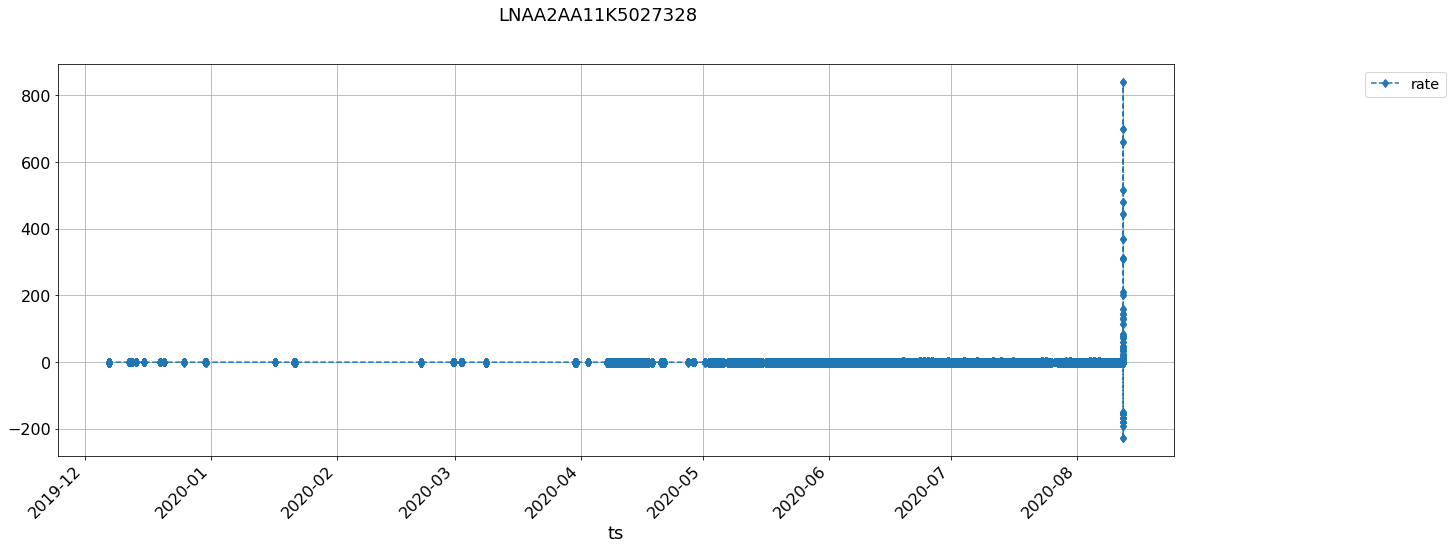

In [345]:
%matplotlib inline
result_list_pd2['rate'].iloc[453550:].plot(   
    figsize=(20, 8), 
    style="d--", 
    grid=True, 
)
plt.legend(fontsize='x-large', ncol=2, bbox_to_anchor=(1.25, 1.00))
plt.yticks(fontsize=16)
plt.xlim(x['Time'][0],x['Time'][35])
plt.xticks(fontsize=16, rotation=45)
plt.xlabel('ts', fontsize=18)
plt.suptitle('LNAA2AA11K5027328', fontsize=18)

In [ ]:
%matplotlib inline
result_list_pd3=result_list_pd2.copy()
result_list_pd3.reset_index(inplace=True)
result_list_pd3['rate'].plot(   
    figsize=(20, 8), 
    style="d--", 
    grid=True, 
)
plt.legend(fontsize='x-large', ncol=2, bbox_to_anchor=(1.25, 1.00))
plt.yticks(fontsize=16)
plt.xlim(x['Time'][0],x['Time'][35])
plt.xticks(fontsize=16, rotation=45)
plt.xlabel('ts', fontsize=18)
plt.suptitle('LNAA2AA11K5027328', fontsize=18)